# Métodos de Ensemble - Random Forest

- Vamos passar a estudar um dos algoritmos de machine learning mais poderosos que existe, o **random forest**.
- Ele faz parte de um conjunto de métodos chamados de *ensemble*, que funcionam como um grupo de preditores, que em conjunto dão resultados melhores do que cada um individualmente.
    - Exemplo: na aula passada vimos árvores de decisão. Usando o método de ensembles, podemos treinar um grupo de árvores de decisão, cada um sobre um subconjunto de treino diferente e aleatório.
- Métodos de ensemble populares: bagging, boosting e stacking.

---
No scikit learning, os métodos de ensemble estão dentro do método `sklearn.ensemble`

Vamos começar pelo "classificador votante" (Voting Classifier)


## Voting Classifier

`from sklearn.ensemble import VotingClassifier`

A ideia por trás do VotingClassifier é combinar classificadores, conceitualmente diferentes e usar um voto majoritário, ou as probabilidades previstas (médias) para prever as classes. Em um conjunto de modelos de desempenho igualmente bons, este classificador é útil para equilibrar suas fraquezas individuais.



<img src="https://i.stack.imgur.com/W7UmY.png" alt="drawing"  width="600"/>



In [178]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns

vamos criar um dataset com 1000 pontos usando a lib `make_moons()` do `sklearn.datasets`

    n_samples >> quantos pontos queremos

    noise >> o quão espalhados os pontoes estão. noise = 0, estão concentrados em duas curvas bem distintas.
----
# Atividade
teste diferentes valores de n_samples e noise e veja como o dataset muda.

In [126]:
X, y = make_moons(n_samples=1000, noise=1.3, random_state=42)
X

array([[-7.73832090e-01,  1.35649994e+00],
       [ 2.35961183e+00,  5.06224622e-01],
       [-1.15034875e-04,  2.66579058e+00],
       ...,
       [ 2.20444677e+00, -1.31550375e+00],
       [-1.53462301e+00, -1.27764437e+00],
       [ 6.29085304e-01,  8.28715204e-01]])

Text(0.5, 1.0, 'Data')

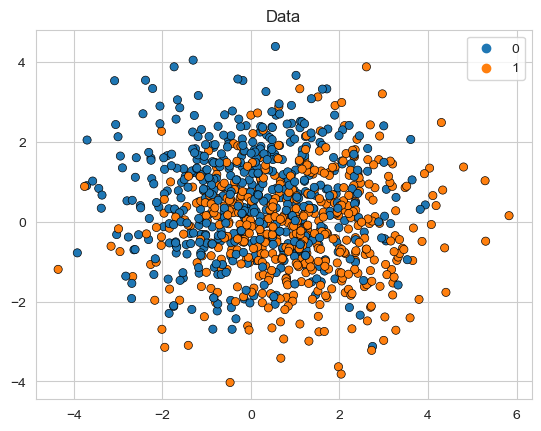

In [127]:
sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=35, edgecolor="k", legend=True
).set_title("Data")

Vamos agora instanciar os modelos que usaremos para realizar a classificação.

Usamos então, o `VotingClassifier` para determinar qual melhor modelo.

In [179]:
rnf_clf = RandomForestClassifier(n_estimators=40)
svm_clf = SVC()
lgr_clf = LogisticRegression()
det_clf = DecisionTreeClassifier()
voting_clf = VotingClassifier(
    estimators=[("rnf", rnf_clf), ("det", det_clf), ("svc", svm_clf), ("lf", lgr_clf)],
    voting="hard"
)

voting_clf.fit(X, y)

VotingClassifier(estimators=[('rnf', RandomForestClassifier(n_estimators=40)),
                             ('det', DecisionTreeClassifier()), ('svc', SVC()),
                             ('lf', LogisticRegression())])

Agora podemos avaliar os resultados dos modelos.

Podemos fazer isso em um loop `for`, como abaixo.

In [181]:
for clf in (rnf_clf, det_clf, svm_clf, lgr_clf, voting_clf):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), clf.__class__.__name__))

Accuracy: 0.90 (+/- 0.03) [RandomForestClassifier]
Accuracy: 0.86 (+/- 0.01) [DecisionTreeClassifier]
Accuracy: 0.86 (+/- 0.02) [SVC]
Accuracy: 0.87 (+/- 0.03) [LogisticRegression]
Accuracy: 0.89 (+/- 0.03) [VotingClassifier]


# Atividade

Aproveitando as variações que você fez na hora de criar o dataset, faça testes com diferentes valores de n_samples e noises, monte uma tabela com os resultados e analise.

1. n_samples = 100 noise = 0.15
    Accuracy: 0.99 (+/- 0.01) [RandomForestClassifier]
    Accuracy: 0.99 (+/- 0.01) [SVC]
    Accuracy: 0.87 (+/- 0.02) [LogisticRegression]
    Accuracy: 0.99 (+/- 0.01) [VotingClassifier]

2. n_samples = 1000 noise = 0.90
    Accuracy: 0.69 (+/- 0.02) [RandomForestClassifier]
    Accuracy: 0.73 (+/- 0.02) [SVC]
    Accuracy: 0.72 (+/- 0.02) [LogisticRegression]
    Accuracy: 0.73 (+/- 0.02) [VotingClassifier]

3 n_samples = 1000 noise = 0.99
    Accuracy: 0.68 (+/- 0.03) [RandomForestClassifier]
    Accuracy: 0.71 (+/- 0.02) [SVC]
    Accuracy: 0.71 (+/- 0.01) [LogisticRegression]
    Accuracy: 0.71 (+/- 0.01) [VotingClassifier]

4 n_samples = 1000 noise = 1.3
    Accuracy: 0.61 (+/- 0.02) [RandomForestClassifier]
    Accuracy: 0.67 (+/- 0.01) [SVC]
    Accuracy: 0.67 (+/- 0.01) [LogisticRegression]
    Accuracy: 0.67 (+/- 0.01) [VotingClassifier]

----
# Grid Search

Desde que começamos a estudar o sklearn, vimos diferentes modelos, e cada modelo possui
um conjunto de hiperparâmetros que precisam ser ajustados para se ter o melhor resultado.

Por exemplo, quando estudamos SVM`s vimos dois hiperparâmetros que podemos mudar
para realizar ajustes que julgarmos necessários: $C$ e o kernel.

Naquele momento, mudamos principalmente o $C$ com o objetivo de obtermos a melhor
fronteira de classificação. Mas isto foi feito manualmente, o que é contra-producente.

Existe uma maneira de automatizarmos estes testes e obtermos o melhor conjunto
de hiperparâmetros possível. Aqui estamos falando do **GridSearch**:

    O GridSearch é uma técnica de ajuste que tenta calcular os valores ótimos
    dos hiperparâmetros.
    É uma busca exaustiva que é realizada nos valores de parâmetros específicos de um modelo.

Vamos implementar o **GridSearch** em uma classificação.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [177]:
X, y = make_classification(n_samples=1000, random_state=42)
y

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,

In [169]:
x = [i for i in range(1, 30)]

param_grid = {'max_depth': x,
              'min_samples_split': [2, 5, 10]}

In [170]:
base_estimator = RandomForestClassifier(random_state=42)

In [171]:
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2, resource='n_estimators',
                         max_resources=30).fit(X, y)

In [173]:
# Verificando qual o melhor modelo

model = sh.best_estimator_

In [174]:
model

RandomForestClassifier(max_depth=9, min_samples_split=10, n_estimators=16,
                       random_state=42)

In [176]:
model.predict(X)

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,

# Atividade
Volte no notebook da aula passada e realize um GridSearch para o problema de classificação Iris com SVC

In [111]:
import numpy as np

In [113]:
x = np.array([x for x in range(100)])
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [115]:
import matplotlib.pyplot as plt

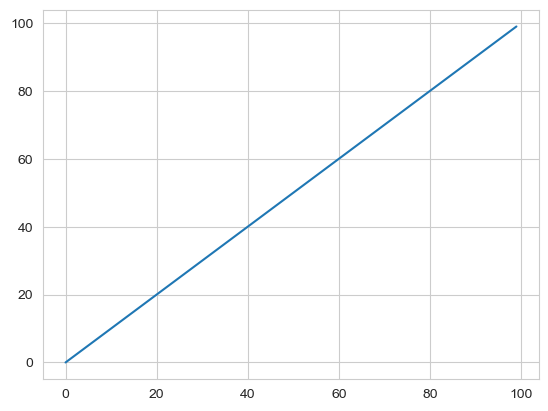

In [116]:
plt.plot(x)

In [118]:
x

array([ 0.5813137,  1.5813137,  2.5813137,  3.5813137,  4.5813137,
        5.5813137,  6.5813137,  7.5813137,  8.5813137,  9.5813137,
       10.5813137, 11.5813137, 12.5813137, 13.5813137, 14.5813137,
       15.5813137, 16.5813137, 17.5813137, 18.5813137, 19.5813137,
       20.5813137, 21.5813137, 22.5813137, 23.5813137, 24.5813137,
       25.5813137, 26.5813137, 27.5813137, 28.5813137, 29.5813137,
       30.5813137, 31.5813137, 32.5813137, 33.5813137, 34.5813137,
       35.5813137, 36.5813137, 37.5813137, 38.5813137, 39.5813137,
       40.5813137, 41.5813137, 42.5813137, 43.5813137, 44.5813137,
       45.5813137, 46.5813137, 47.5813137, 48.5813137, 49.5813137,
       50.5813137, 51.5813137, 52.5813137, 53.5813137, 54.5813137,
       55.5813137, 56.5813137, 57.5813137, 58.5813137, 59.5813137,
       60.5813137, 61.5813137, 62.5813137, 63.5813137, 64.5813137,
       65.5813137, 66.5813137, 67.5813137, 68.5813137, 69.5813137,
       70.5813137, 71.5813137, 72.5813137, 73.5813137, 74.5813